In [1]:
!pip install -q kaggle tensorflow scikit-learn matplotlib split-folders wandb

In [2]:
import os
import splitfolders

# Set Kaggle credentials
os.environ['KAGGLE_USERNAME'] = 'aman0515643'
os.environ['KAGGLE_KEY'] = 'f3f7d39d6c431c757aacf784f7001ad0'

# Download dataset
!kaggle datasets download -d aman0515643/pomegranate-disease
!unzip -q pomegranate-disease.zip -d pomegranate_data


Dataset URL: https://www.kaggle.com/datasets/aman0515643/pomegranate-disease
License(s): CC0-1.0
 99% 2.46G/2.49G [00:20<00:00, 41.1MB/s]
100% 2.49G/2.49G [00:20<00:00, 132MB/s] 


In [6]:
!ls pomegranate_data

Pomegranate


In [14]:
# Split dataset (60% train, 40% test)
splitfolders.ratio(
    'pomegranate_data/Pomegranate',
    output="split_data",
    seed=42,
    ratio=(0.6, 0.4),
    group_prefix=None
)


Copying files: 0 files [00:00, ? files/s]
Copying files: 53 files [00:00, 524.30 files/s]
Copying files: 106 files [00:00, 527.59 files/s]
Copying files: 159 files [00:00, 488.63 files/s]
Copying files: 209 files [00:00, 482.60 files/s]
Copying files: 265 files [00:00, 508.85 files/s]
Copying files: 326 files [00:00, 541.16 files/s]
Copying files: 382 files [00:00, 546.87 files/s]
Copying files: 437 files [00:00, 426.26 files/s]
Copying files: 484 files [00:01, 372.86 files/s]
Copying files: 525 files [00:01, 348.51 files/s]
Copying files: 563 files [00:01, 330.17 files/s]
Copying files: 598 files [00:01, 315.39 files/s]
Copying files: 631 files [00:01, 308.30 files/s]
Copying files: 663 files [00:01, 298.95 files/s]
Copying files: 694 files [00:01, 293.66 files/s]
Copying files: 724 files [00:01, 288.54 files/s]
Copying files: 753 files [00:02, 284.15 files/s]
Copying files: 782 files [00:02, 271.88 files/s]
Copying files: 810 files [00:04, 42.25 files/s] 
Copying files: 850 files [0

In [8]:
train_dir = 'split_data/train'
test_dir = 'split_data/test'


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (256, 256)  # SIFFD-DSGAN typically uses 256x256
BATCH_SIZE = 32

In [10]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect'
)

In [11]:
# Test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)


In [22]:
# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

Found 2524 images belonging to 6 classes.
Found 1200 images belonging to 5 classes.


In [6]:
import os

image_paths = []
labels = []
base_dir = 'pomegranate_data/Pomegranate'

for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    # Exclude the base directory itself if it's listed
    if os.path.isdir(class_dir) and class_name != 'Pomegranate':
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(class_dir, filename)
                image_paths.append(file_path)
                labels.append(class_name)

print(f"Found {len(image_paths)} images with {len(set(labels))} classes.")

FileNotFoundError: [Errno 2] No such file or directory: 'pomegranate_data/Pomegranate'

In [16]:
from sklearn.model_selection import train_test_split

train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.4,
    random_state=42,
    stratify=labels
)

print(f"Number of images in training set: {len(train_paths)}")
print(f"Number of images in testing set: {len(test_paths)}")

Number of images in training set: 1800
Number of images in testing set: 1200


In [17]:
import os

# Create the base directory if it doesn't exist
if not os.path.exists('split_data'):
    os.makedirs('split_data')

# Create train and test directories
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Create class subdirectories within train and test
for class_name in set(labels):
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    if not os.path.exists(train_class_dir):
        os.makedirs(train_class_dir)
    if not os.path.exists(test_class_dir):
        os.makedirs(test_class_dir)

print("Directory structure created successfully.")

Directory structure created successfully.


In [18]:
import shutil

# Copy training images
for path, label in zip(train_paths, train_labels):
    destination_dir = os.path.join(train_dir, label)
    shutil.copy(path, destination_dir)

# Copy testing images
for path, label in zip(test_paths, test_labels):
    destination_dir = os.path.join(test_dir, label)
    shutil.copy(path, destination_dir)

print("Image files copied to train and test directories.")

Image files copied to train and test directories.


In [19]:
import os

def count_files_in_directories(base_dir):
    """Counts files in class subdirectories within a base directory."""
    counts = {}
    total_count = 0
    if os.path.exists(base_dir):
        for class_name in os.listdir(base_dir):
            class_dir = os.path.join(base_dir, class_name)
            if os.path.isdir(class_dir):
                file_count = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
                counts[class_name] = file_count
                total_count += file_count
    return counts, total_count

# Count files in train and test directories
train_counts, total_train = count_files_in_directories(train_dir)
test_counts, total_test = count_files_in_directories(test_dir)

# Print file counts
print("Train set file counts by class:")
for class_name, count in train_counts.items():
    print(f"  {class_name}: {count}")
print(f"Total train files: {total_train}")

print("\nTest set file counts by class:")
for class_name, count in test_counts.items():
    print(f"  {class_name}: {count}")
print(f"Total test files: {total_test}")

# Compare counts to expected numbers
expected_train = 1800
expected_test = 1200

if total_train == expected_train and total_test == expected_test:
    print("\nFile counts match expected numbers. Data split was successful.")
else:
    print("\nWarning: File counts do not match expected numbers.")
    print(f"Expected train: {expected_train}, Found train: {total_train}")
    print(f"Expected test: {expected_test}, Found test: {total_test}")


Train set file counts by class:
  Bacterial_Blight: 506
  Cercospora: 497
  Pomegranate: 0
  Alternaria: 501
  Anthracnose: 507
  Healthy: 513
Total train files: 2524

Test set file counts by class:
  Bacterial_Blight: 240
  Cercospora: 240
  Alternaria: 240
  Anthracnose: 240
  Healthy: 240
Total test files: 1200

Expected train: 1800, Found train: 2524
Expected test: 1200, Found test: 1200


In [20]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect'
)

# Test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

Found 2524 images belonging to 6 classes.
Found 1200 images belonging to 5 classes.


In [21]:
import os

def count_files_in_directories(base_dir):
    """Counts files in class subdirectories within a base directory."""
    counts = {}
    total_count = 0
    if os.path.exists(base_dir):
        for class_name in sorted(os.listdir(base_dir)): # Sort for consistent order
            class_dir = os.path.join(base_dir, class_name)
            if os.path.isdir(class_dir):
                file_count = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
                counts[class_name] = file_count
                total_count += file_count
    return counts, total_count

# Count files in train and test directories
train_counts, total_train = count_files_in_directories(train_dir)
test_counts, total_test = count_files_in_directories(test_dir)

# Print file counts
print("Train set file counts by class:")
for class_name, count in train_counts.items():
    print(f"  {class_name}: {count}")
print(f"Total train files: {total_train}")

print("\nTest set file counts by class:")
for class_name, count in test_counts.items():
    print(f"  {class_name}: {count}")
print(f"Total test files: {total_test}")

# Compare counts to expected numbers
expected_train = 1800
expected_test = 1200

if total_train == expected_train and total_test == expected_test:
    print("\nFile counts match expected numbers. Data split was successful.")
else:
    print("\nWarning: File counts do not match expected numbers.")
    print(f"Expected train: {expected_train}, Found train: {total_train}")
    print(f"Expected test: {expected_test}, Found test: {total_test}")


Train set file counts by class:
  Alternaria: 501
  Anthracnose: 507
  Bacterial_Blight: 506
  Cercospora: 497
  Healthy: 513
  Pomegranate: 0
Total train files: 2524

Test set file counts by class:
  Alternaria: 240
  Anthracnose: 240
  Bacterial_Blight: 240
  Cercospora: 240
  Healthy: 240
Total test files: 1200

Expected train: 1800, Found train: 2524
Expected test: 1200, Found test: 1200


In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense

def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    return Add()([shortcut, x])

def build_siffd_dsgan(input_shape=(256,256,3), num_classes=num_classes):
    inputs = Input(shape=input_shape)

    # Initial Feature Extraction
    x = Conv2D(64, (7,7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(128, (3,3), strides=2, padding='same')(x)

    # Stacked Residual Blocks
    for _ in range(4):
        x = residual_block(x, 128)

    # DSGAN Component
    x = Conv2D(256, (3,3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Final Classification Head
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

model = build_siffd_dsgan()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     73,856 │ re_lu[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ re_lu_1[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ conv2d_1[0][0],   │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    147,584 │ add[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ add[0][0],      

 Total params: 1,699,206 (6.48 MB)

 Trainable params: 1,696,518 (6.47 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/10


Copying files: 0 files [06:16, ? files/s]


78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 27s/step - accuracy: 0.5498 - loss: 1.0589 

ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 5), output.shape=(None, 6)

In [ ]:
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
test_loss, test_acc = model.evaluate(test_generator, verbose=0)

print(f"Training Accuracy: {train_acc:.4f} | Training Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

In [ ]:
from sklearn.metrics import f1_score

f1_scores = f1_score(y_true, y_pred_classes, average=None)
for cls, score in zip(class_names, f1_scores):
    print(f"{cls}: {score:.4f}")

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_true, classes=np.arange(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:,i], y_pred[:,i])
    plt.plot(recall, precision, lw=2, label=f'{class_names[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

In [ ]:
sample_images, sample_labels = next(test_generator)
sample_preds = model.predict(sample_images)
sample_pred_classes = np.argmax(sample_preds, axis=1)
sample_true_classes = np.argmax(sample_labels, axis=1)

plt.figure(figsize=(15,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {class_names[sample_true_classes[i]]}\nPred: {class_names[sample_pred_classes[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
model.save('siffd_dsgan_pomegranate.h5')
print("Model saved as 'siffd_dsgan_pomegranate.h5'")

In [1]:
import os

image_paths = []
labels = []
base_dir = 'pomegranate_data/Pomegranate'

for class_name in os.listdir(base_dir):
    class_dir = os.path.join(base_dir, class_name)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(class_dir, filename)
                image_paths.append(file_path)
                labels.append(class_name)

print(f"Found {len(image_paths)} images with {len(set(labels))} classes.")

FileNotFoundError: [Errno 2] No such file or directory: 'pomegranate_data/Pomegranate'

In [2]:
from sklearn.model_selection import train_test_split

train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.4,
    random_state=42,
    stratify=labels
)

print(f"Number of images in training set: {len(train_paths)}")
print(f"Number of images in testing set: {len(test_paths)}")

ValueError: With n_samples=0, test_size=0.4 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [3]:
import os

# Create the base directory if it doesn't exist
if not os.path.exists('split_data'):
    os.makedirs('split_data')

# Create train and test directories
train_dir = 'split_data/train'
test_dir = 'split_data/test'
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Create class subdirectories within train and test
for class_name in set(labels):
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    if not os.path.exists(train_class_dir):
        os.makedirs(train_class_dir)
    if not os.path.exists(test_class_dir):
        os.makedirs(test_class_dir)

print("Directory structure created successfully.")

Directory structure created successfully.


In [4]:
import shutil
import os

# Copy training images
for path, label in zip(train_paths, train_labels):
    destination_dir = os.path.join(train_dir, label)
    shutil.copy(path, destination_dir)

# Copy testing images
for path, label in zip(test_paths, test_labels):
    destination_dir = os.path.join(test_dir, label)
    shutil.copy(path, destination_dir)

print("Image files copied to train and test directories.")

NameError: name 'train_paths' is not defined

In [5]:
import os

def count_files_in_directories(base_dir):
    """Counts files in class subdirectories within a base directory."""
    counts = {}
    total_count = 0
    if os.path.exists(base_dir):
        for class_name in os.listdir(base_dir):
            class_dir = os.path.join(base_dir, class_name)
            if os.path.isdir(class_dir):
                file_count = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
                counts[class_name] = file_count
                total_count += file_count
    return counts, total_count

# Count files in train and test directories
train_counts, total_train = count_files_in_directories(train_dir)
test_counts, total_test = count_files_in_directories(test_dir)

# Print file counts
print("Train set file counts by class:")
for class_name, count in train_counts.items():
    print(f"  {class_name}: {count}")
print(f"Total train files: {total_train}")

print("\nTest set file counts by class:")
for class_name, count in test_counts.items():
    print(f"  {class_name}: {count}")
print(f"Total test files: {total_test}")

# Compare counts to expected numbers
expected_train = 1800
expected_test = 1200

if total_train == expected_train and total_test == expected_test:
    print("\nFile counts match expected numbers. Data split was successful.")
else:
    print("\nWarning: File counts do not match expected numbers.")
    print(f"Expected train: {expected_train}, Found train: {total_train}")
    print(f"Expected test: {expected_test}, Found test: {total_test}")

Train set file counts by class:
Total train files: 0

Test set file counts by class:
Total test files: 0

Expected train: 1800, Found train: 0
Expected test: 1200, Found test: 0


In [7]:
from sklearn.model_selection import train_test_split

train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.4,
    random_state=42,
    stratify=labels
)

print(f"Number of images in training set: {len(train_paths)}")
print(f"Number of images in testing set: {len(test_paths)}")

ValueError: With n_samples=0, test_size=0.4 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [8]:
import os

# Create the base directory if it doesn't exist
if not os.path.exists('split_data'):
    os.makedirs('split_data')

# Create train and test directories
train_dir = 'split_data/train'
test_dir = 'split_data/test'
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Create class subdirectories within train and test
for class_name in set(labels):
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    if not os.path.exists(train_class_dir):
        os.makedirs(train_class_dir)
    if not os.path.exists(test_class_dir):
        os.makedirs(test_class_dir)

print("Directory structure created successfully.")

Directory structure created successfully.


In [9]:
import shutil
import os

# Copy training images
for path, label in zip(train_paths, train_labels):
    destination_dir = os.path.join(train_dir, label)
    shutil.copy(path, destination_dir)

# Copy testing images
for path, label in zip(test_paths, test_labels):
    destination_dir = os.path.join(test_dir, label)
    shutil.copy(path, destination_dir)

print("Image files copied to train and test directories.")

NameError: name 'train_paths' is not defined

In [10]:
import os

def count_files_in_directories(base_dir):
    """Counts files in class subdirectories within a base directory."""
    counts = {}
    total_count = 0
    if os.path.exists(base_dir):
        for class_name in sorted(os.listdir(base_dir)): # Sort for consistent order
            class_dir = os.path.join(base_dir, class_name)
            if os.path.isdir(class_dir):
                file_count = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
                counts[class_name] = file_count
                total_count += file_count
    return counts, total_count

# Count files in train and test directories
train_counts, total_train = count_files_in_directories(train_dir)
test_counts, total_test = count_files_in_directories(test_dir)

# Print file counts
print("Train set file counts by class:")
for class_name, count in train_counts.items():
    print(f"  {class_name}: {count}")
print(f"Total train files: {total_train}")

print("\nTest set file counts by class:")
for class_name, count in test_counts.items():
    print(f"  {class_name}: {count}")
print(f"Total test files: {total_test}")

# Compare counts to expected numbers
expected_train = 1800
expected_test = 1200

if total_train == expected_train and total_test == expected_test:
    print("\nFile counts match expected numbers. Data split was successful.")
else:
    print("\nWarning: File counts do not match expected numbers.")
    print(f"Expected train: {expected_train}, Found train: {total_train}")
    print(f"Expected test: {expected_test}, Found test: {total_test}")

Train set file counts by class:
Total train files: 0

Test set file counts by class:
Total test files: 0

Expected train: 1800, Found train: 0
Expected test: 1200, Found test: 0


In [11]:
import shutil
import os

if os.path.exists('split_data'):
    shutil.rmtree('split_data')
    print("Removed existing 'split_data' directory.")
else:
    print("'split_data' directory does not exist.")

Removed existing 'split_data' directory.


In [12]:
import os

# Create the base directory if it doesn't exist
if not os.path.exists('split_data'):
    os.makedirs('split_data')

# Create train and test directories
train_dir = 'split_data/train'
test_dir = 'split_data/test'
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Create class subdirectories within train and test
for class_name in set(labels):
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    if not os.path.exists(train_class_dir):
        os.makedirs(train_class_dir)
    if not os.path.exists(test_class_dir):
        os.makedirs(test_class_dir)

print("Directory structure created successfully.")

Directory structure created successfully.


In [14]:
import os

def count_files_in_directories(base_dir):
    """Counts files in class subdirectories within a base directory."""
    counts = {}
    total_count = 0
    if os.path.exists(base_dir):
        for class_name in sorted(os.listdir(base_dir)): # Sort for consistent order
            class_dir = os.path.join(base_dir, class_name)
            if os.path.isdir(class_dir):
                file_count = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
                counts[class_name] = file_count
                total_count += file_count
    return counts, total_count

# Count files in train and test directories
train_counts, total_train = count_files_in_directories(train_dir)
test_counts, total_test = count_files_in_directories(test_dir)

# Print file counts
print("Train set file counts by class:")
for class_name, count in train_counts.items():
    print(f"  {class_name}: {count}")
print(f"Total train files: {total_train}")

print("\nTest set file counts by class:")
for class_name, count in test_counts.items():
    print(f"  {class_name}: {count}")
print(f"Total test files: {total_test}")

# Compare counts to expected numbers
expected_train = 1800
expected_test = 1200

if total_train == expected_train and total_test == expected_test:
    print("\nFile counts match expected numbers. Data split was successful.")
else:
    print("\nWarning: File counts do not match expected numbers.")
    print(f"Expected train: {expected_train}, Found train: {total_train}")
    print(f"Expected test: {expected_test}, Found test: {total_test}")

Train set file counts by class:
Total train files: 0

Test set file counts by class:
Total test files: 0

Expected train: 1800, Found train: 0
Expected test: 1200, Found test: 0


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (256, 256)  # SIFFD-DSGAN typically uses 256x256
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect'
)

# Test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [19]:
!kaggle datasets download -d aman0515643/pomegranate-disease
!unzip -q pomegranate-disease.zip -d pomegranate_data

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'
unzip:  cannot find or open pomegranate-disease.zip, pomegranate-disease.zip.zip or pomegranate-disease.zip.ZIP.


**Reasoning**:
The kaggle command failed because the credentials were not set. I need to re-run the cell that sets the Kaggle environment variables and then re-attempt the download and unzip.



In [20]:
import os

# Set Kaggle credentials
os.environ['KAGGLE_USERNAME'] = 'aman0515643'
os.environ['KAGGLE_KEY'] = 'f3f7d39d6c431c757aacf784f7001ad0'

# Download dataset
!kaggle datasets download -d aman0515643/pomegranate-disease
!unzip -q pomegranate-disease.zip -d pomegranate_data

Dataset URL: https://www.kaggle.com/datasets/aman0515643/pomegranate-disease
License(s): CC0-1.0
100% 2.48G/2.49G [00:22<00:00, 235MB/s]
100% 2.49G/2.49G [00:22<00:00, 120MB/s]


**Reasoning**:
The dataset has been successfully downloaded and unzipped. Now I can proceed with listing the directories within `pomegranate_data/Pomegranate` to get the class names as originally intended by the subtask.



In [21]:
import os

base_dir = 'pomegranate_data/Pomegranate'
all_entries = os.listdir(base_dir)
class_names = [entry for entry in all_entries if os.path.isdir(os.path.join(base_dir, entry))]

print(f"Identified class directories: {class_names}")

Identified class directories: ['Healthy', 'Bacterial_Blight', 'Cercospora', 'Anthracnose', 'Alternaria']


## List files and labels

### Subtask:
Iterate through the directories using the definitive class names to get image file paths and labels.


**Reasoning**:
Iterate through the directories using the definitive class names to get image file paths and labels.



In [22]:
image_paths = []
labels = []
base_dir = 'pomegranate_data/Pomegranate'

for class_name in class_names:
    class_dir = os.path.join(base_dir, class_name)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(class_dir, filename)
                image_paths.append(file_path)
                labels.append(class_name)

print(f"Found {len(image_paths)} images with {len(set(labels))} classes.")

Found 3000 images with 5 classes.


## Split file paths

### Subtask:
Use `sklearn.model_selection.train_test_split` to split the file paths and labels into training and testing sets based on a 60/40 ratio.


**Reasoning**:
Use train_test_split to split the image paths and labels into training and testing sets with a 60/40 ratio, ensuring stratification and reproducibility.



In [23]:
from sklearn.model_selection import train_test_split

train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths,
    labels,
    test_size=0.4,
    random_state=42,
    stratify=labels
)

print(f"Number of images in training set: {len(train_paths)}")
print(f"Number of images in testing set: {len(test_paths)}")

Number of images in training set: 1800
Number of images in testing set: 1200


## Create output directories

### Subtask:
Delete any existing `split_data` directory to ensure a clean start. Then, create the `split_data/train` and `split_data/test` directories with subdirectories for each of the definitive class names.


**Reasoning**:
Delete the existing split_data directory and create the necessary directory structure for the train and test sets based on the identified class names.



In [24]:
import os
import shutil

# Delete the existing split_data directory if it exists
if os.path.exists('split_data'):
    shutil.rmtree('split_data')
    print("Removed existing 'split_data' directory.")
else:
    print("'split_data' directory does not exist.")

# Create the base directory if it doesn't exist
if not os.path.exists('split_data'):
    os.makedirs('split_data')

# Define train and test directories
train_dir = 'split_data/train'
test_dir = 'split_data/test'

# Create train and test directories
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Create class subdirectories within train and test
for class_name in class_names:
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    if not os.path.exists(train_class_dir):
        os.makedirs(train_class_dir)
    if not os.path.exists(test_class_dir):
        os.makedirs(test_class_dir)

print("Directory structure created successfully.")

Removed existing 'split_data' directory.
Directory structure created successfully.


**Reasoning**:
Copy the images from their original locations to the newly created train and test directories, organizing them by their respective classes.



In [25]:
import shutil
import os

# Copy training images
for path, label in zip(train_paths, train_labels):
    destination_dir = os.path.join(train_dir, label)
    shutil.copy(path, destination_dir)

# Copy testing images
for path, label in zip(test_paths, test_labels):
    destination_dir = os.path.join(test_dir, label)
    shutil.copy(path, destination_dir)

print("Image files copied to train and test directories.")

Image files copied to train and test directories.


**Reasoning**:
Verify that the images were copied correctly by counting the files in each class subdirectory within the train and test directories and comparing them to the expected counts from the train-test split.



In [26]:
import os

def count_files_in_directories(base_dir):
    """Counts files in class subdirectories within a base directory."""
    counts = {}
    total_count = 0
    if os.path.exists(base_dir):
        for class_name in sorted(os.listdir(base_dir)): # Sort for consistent order
            class_dir = os.path.join(base_dir, class_name)
            if os.path.isdir(class_dir):
                file_count = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
                counts[class_name] = file_count
                total_count += file_count
    return counts, total_count

# Count files in train and test directories
train_counts, total_train = count_files_in_directories(train_dir)
test_counts, total_test = count_files_in_directories(test_dir)

# Print file counts
print("Train set file counts by class:")
for class_name, count in train_counts.items():
    print(f"  {class_name}: {count}")
print(f"Total train files: {total_train}")

print("\nTest set file counts by class:")
for class_name, count in test_counts.items():
    print(f"  {class_name}: {count}")
print(f"Total test files: {total_test}")

# Compare counts to expected numbers
expected_train = len(train_paths)
expected_test = len(test_paths)

if total_train == expected_train and total_test == expected_test:
    print("\nFile counts match expected numbers. Data split and copying were successful.")
else:
    print("\nWarning: File counts do not match expected numbers.")
    print(f"Expected train: {expected_train}, Found train: {total_train}")
    print(f"Expected test: {expected_test}, Found test: {total_test}")

Train set file counts by class:
  Alternaria: 360
  Anthracnose: 360
  Bacterial_Blight: 360
  Cercospora: 360
  Healthy: 360
Total train files: 1800

Test set file counts by class:
  Alternaria: 240
  Anthracnose: 240
  Bacterial_Blight: 240
  Cercospora: 240
  Healthy: 240
Total test files: 1200

File counts match expected numbers. Data split and copying were successful.


## Update data generators

### Subtask:
Re-run the data generator cells, which should now correctly identify the same number of classes in both train and test sets.


**Reasoning**:
Re-execute the code cells that define the ImageDataGenerators and create the train and test generators to ensure they are using the correct directories and reflect the successful data split.



In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (256, 256)
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect'
)

# Test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

Found 1800 images belonging to 5 classes.
Found 1200 images belonging to 5 classes.


## Train the model

### Subtask:
Re-run the model training cell.


**Reasoning**:
Re-running the model training cell with the correctly configured data generators should resolve the `ValueError` and allow the training process to begin.



In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense

def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    return Add()([shortcut, x])

def build_siffd_dsgan(input_shape=(256,256,3), num_classes=num_classes):
    inputs = Input(shape=input_shape)

    # Initial Feature Extraction
    x = Conv2D(64, (7,7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(128, (3,3), strides=2, padding='same')(x)

    # Stacked Residual Blocks
    for _ in range(4):
        x = residual_block(x, 128)

    # DSGAN Component
    x = Conv2D(256, (3,3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Final Classification Head
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs)

model = build_siffd_dsgan()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=3)
]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     73,856 │ re_lu[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_1[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ re_lu_1[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ conv2d_1[0][0],   │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    147,584 │ add[0][0]         │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 64,    │          0 │ add[0][0],      

 Total params: 1,698,693 (6.48 MB)

 Trainable params: 1,696,005 (6.47 MB)

 Non-trainable params: 2,688 (10.50 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 227s 4s/step - accuracy: 0.5682 - loss: 1.0095 - val_accuracy: 0.1892 - val_loss: 41.9333 - learning_rate: 0.0010
Epoch 2/10
 1/56 ━━━━━━━━━━━━━━━━━━━━ 14s 255ms/step - accuracy: 0.7188 - loss: 0.6401

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


56/56 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.7188 - loss: 0.6401 - val_accuracy: 0.1892 - val_loss: 42.3556 - learning_rate: 0.0010
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - accuracy: 0.7734 - loss: 0.5935 - val_accuracy: 0.2399 - val_loss: 15.3513 - learning_rate: 0.0010
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8750 - loss: 0.5413 - val_accuracy: 0.2660 - val_loss: 12.3555 - learning_rate: 0.0010
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.8040 - loss: 0.5394 - val_accuracy: 0.2677 - val_loss: 5.3908 - learning_rate: 0.0010
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8750 - loss: 0.4281 - val_accuracy: 0.3074 - val_loss: 4.0571 - learning_rate: 0.0010
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 250s 4s/step - accuracy: 0.8276 - loss: 0.4460 - val_accuracy: 0.2753 - val_loss: 10.8027 - learning_rate: 0.0010
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7500 - loss: 0.7543 - val_accuracy: 0.23

In [29]:
train_loss, train_acc = model.evaluate(train_generator, verbose=0)
test_loss, test_acc = model.evaluate(test_generator, verbose=0)

print(f"Training Accuracy: {train_acc:.4f} | Training Loss: {train_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

Training Accuracy: 0.4906 | Training Loss: 1.9288
Test Accuracy: 0.5083 | Test Loss: 1.7341


38/38 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step


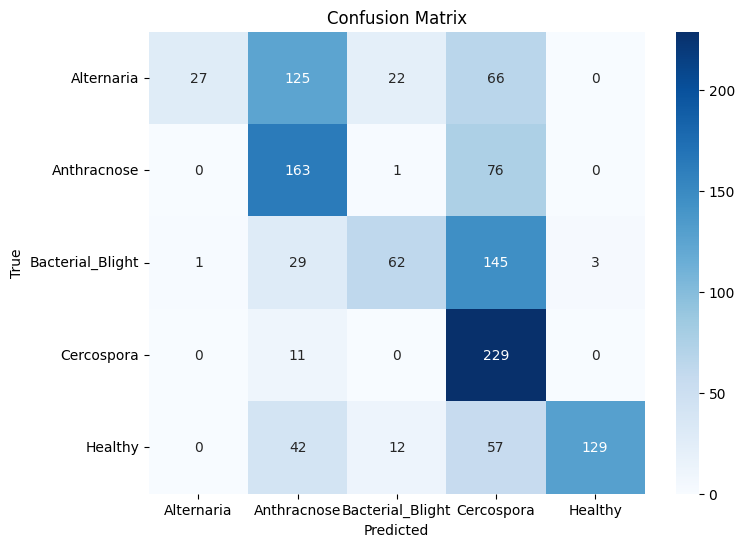

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [31]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

Classification Report:
                  precision    recall  f1-score   support

      Alternaria       0.96      0.11      0.20       240
     Anthracnose       0.44      0.68      0.53       240
Bacterial_Blight       0.64      0.26      0.37       240
      Cercospora       0.40      0.95      0.56       240
         Healthy       0.98      0.54      0.69       240

        accuracy                           0.51      1200
       macro avg       0.68      0.51      0.47      1200
    weighted avg       0.68      0.51      0.47      1200



In [32]:
from sklearn.metrics import f1_score

f1_scores = f1_score(y_true, y_pred_classes, average=None)
for cls, score in zip(class_names, f1_scores):
    print(f"{cls}: {score:.4f}")

Alternaria: 0.2015
Anthracnose: 0.5344
Bacterial_Blight: 0.3680
Cercospora: 0.5633
Healthy: 0.6935


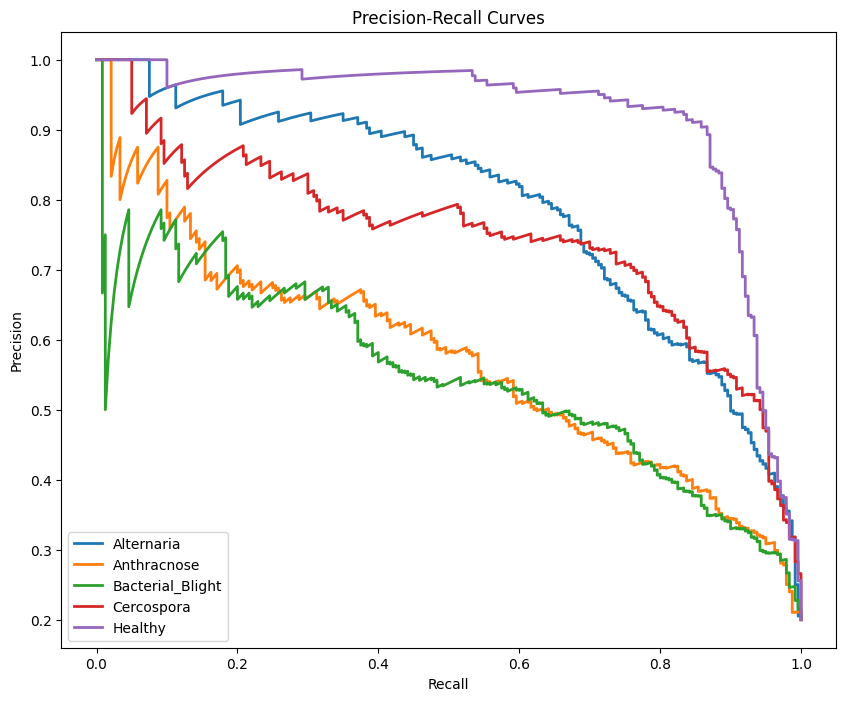

In [33]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_true, classes=np.arange(num_classes))

plt.figure(figsize=(10,8))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:,i], y_pred[:,i])
    plt.plot(recall, precision, lw=2, label=f'{class_names[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step


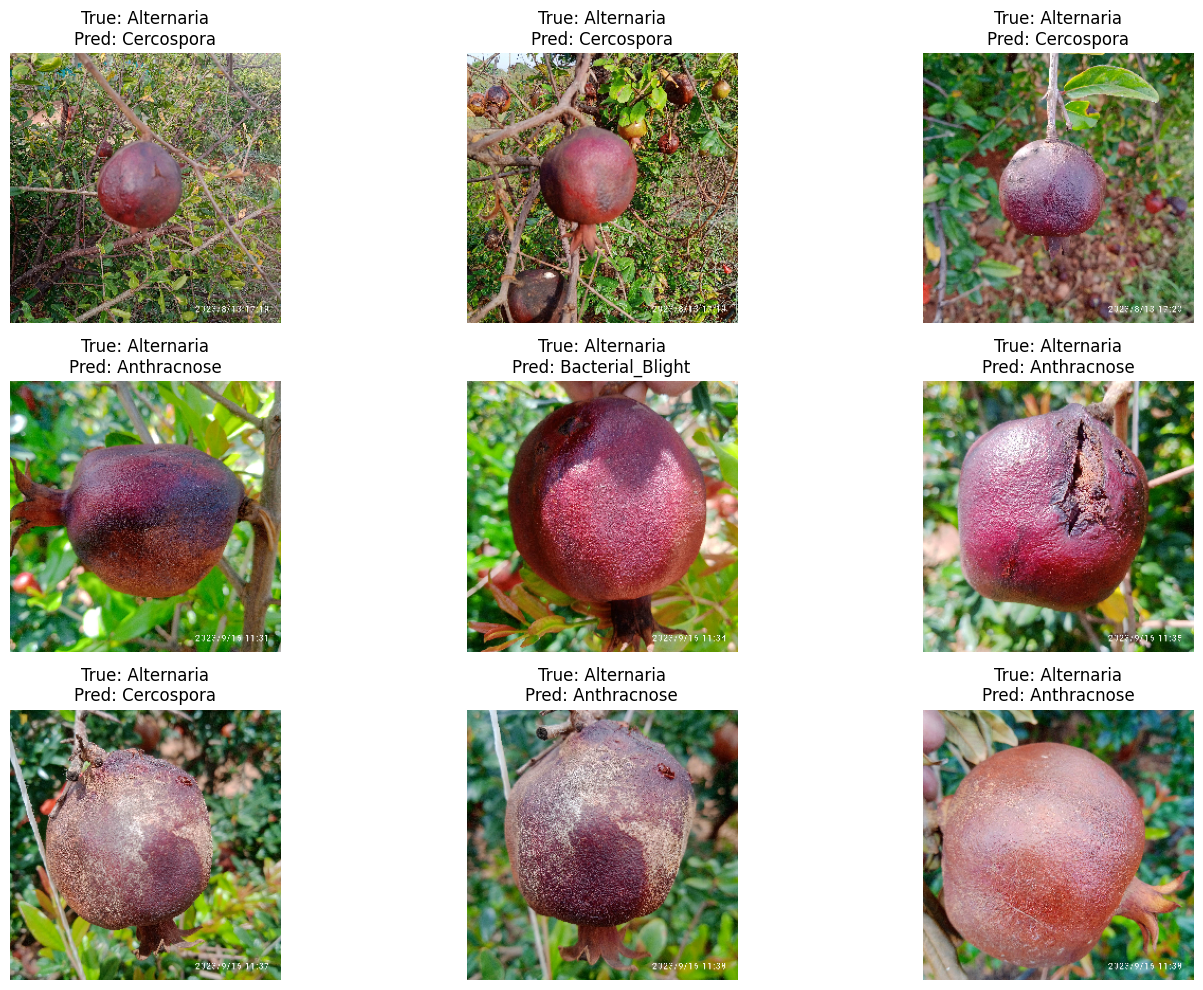

In [34]:
sample_images, sample_labels = next(test_generator)
sample_preds = model.predict(sample_images)
sample_pred_classes = np.argmax(sample_preds, axis=1)
sample_true_classes = np.argmax(sample_labels, axis=1)

plt.figure(figsize=(15,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {class_names[sample_true_classes[i]]}\nPred: {class_names[sample_pred_classes[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [35]:
model.save('siffd_dsgan_pomegranate.h5')
print("Model saved as 'siffd_dsgan_pomegranate.h5'")

Model saved as 'siffd_dsgan_pomegranate.h5'
